In [1]:
import re

from pandas import Series
import pandas as pd
import numpy as np

import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import date
from datetime import datetime, timedelta

from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, precision_score
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.metrics import auc, roc_auc_score, roc_curve

from itertools import combinations
from scipy.stats import ttest_ind
from textblob import TextBlob

import warnings
warnings.filterwarnings("ignore")

import os

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=True, fit_path=Tru

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% ; }</style>"))

In [3]:
pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 200) # показывать больше колонок

In [4]:
# Зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42

In [5]:
# Зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requiremnts.txt

You are using pip version 10.0.1, however version 21.2.4 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [6]:
DATA_DIR = 'input/sf-dst-scoring/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [7]:
# Для корректной обработки данных объединим train и test в один датасет
train['sample'] = 1
test['sample'] = 0
test['default'] = 0 #пока заполним нулями

data = test.append(train, sort=False).reset_index(drop=True)

# Предварительный обзор данных

In [8]:
data.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'sample', 'default'],
      dtype='object')

* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заёмщика
* age - возраст заёмщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля-иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия «хорошей» работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заёмщика
* foreign_passport - наличие загранпаспорта
* default - наличие дефолта

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [10]:
print(data.isna().sum())

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64


В данных о клиентах присутствуют переменные всех типов, не все имеют числовую запись, также есть пропущенные значения. Необходима предварительная очистка данных. Пустые значения есть только в колонке education.

### Предобработка данных

#### Обработка пустых значений

Посмотрим какие значения встречаются в колонке "education"

In [11]:
data['education'].value_counts(dropna=False)

SCH    57998
GRD    34768
UGR    14748
PGR     1865
NaN      478
ACD      291
Name: education, dtype: int64

Значение "SCH" встречается чаще всего, а также можно предположить, что все обучались в школе. Исходя из этого - заполним пустые места в колонке "education" значением "SCH".

In [12]:
data['education'] = data['education'].fillna('SCH')

### Анализ распределения целевой переменной

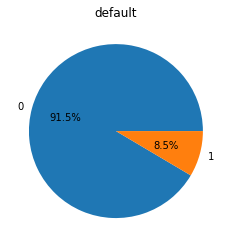

In [13]:
plt.pie(x=data['default'].value_counts(),
       labels=list(data['default'].value_counts().index),
       autopct='%.1f%%',
       textprops={'fontsize': 10})
plt.title('default')
plt.show()

Клиентов без дефолта у банка больше почти в 11 раз. Целевой признак не сбаланисирован, можно будет попробовать применить методы oversampling/undersampling.

### Обработка признаков

#### Исходные признаки сгруппируем в три категории по типу их обработки (категориальные, бинарные и численные) для дальнейшего более удобного анализа

In [14]:
# Для более удобной работы создадим списки по категориям датасета (категориальные,
# бинарные, числовые)

#бинарные переменные
bin_cols=['sex','car','car_type','good_work','foreign_passport']

#категориальные переменные
cat_cols=['education','home_address','work_address','app_date','sna'] 

#численные переменные
num_cols=['age','decline_app_cnt','income','bki_request_cnt','score_bki','region_rating','first_time']

### Численные переменные

#### Выбросы

In [15]:
for col in num_cols:
    median = data[col].median()
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    perc25 = data[col].quantile(0.25)
    perc75 = data[col].quantile(0.75)
    
    print("Column: ", col)
    print("Максимальное значение в данных:", data[col].max())
    print("Минимальное значение в данных:", data[col].min())
    print('25%: {},'.format(perc25), '75%: {},'.format(perc75),
          "IQR: {}, ".format(IQR), "Borderline: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    print()

Column:  age
Максимальное значение в данных: 72
Минимальное значение в данных: 21
25%: 30.0, 75%: 48.0, IQR: 18.0,  Borderline: [3.0, 75.0].

Column:  decline_app_cnt
Максимальное значение в данных: 33
Минимальное значение в данных: 0
25%: 0.0, 75%: 0.0, IQR: 0.0,  Borderline: [0.0, 0.0].

Column:  income
Максимальное значение в данных: 1000000
Минимальное значение в данных: 1000
25%: 20000.0, 75%: 48000.0, IQR: 28000.0,  Borderline: [-22000.0, 90000.0].

Column:  bki_request_cnt
Максимальное значение в данных: 53
Минимальное значение в данных: 0
25%: 0.0, 75%: 3.0, IQR: 3.0,  Borderline: [-4.5, 7.5].

Column:  score_bki
Максимальное значение в данных: 0.19977285
Минимальное значение в данных: -3.62458632
25%: -2.2604336700000003, 75%: -1.5678881525, IQR: 0.6925455175000004,  Borderline: [-3.299251946250001, -0.5290698762499992].

Column:  region_rating
Максимальное значение в данных: 80
Минимальное значение в данных: 20
25%: 50.0, 75%: 60.0, IQR: 10.0,  Borderline: [35.0, 75.0].

Colu

Можно увидеть, что "выбросы" наблюдаются в признаках decline_app_cnt, income и bki_request_cnt.
Однако, удалять их будет не совсем корректно из-за того, что за этими значениями находятся реальные данные: у некоторых людей доход в разы превышает средний, 
количество отказанных прошлых заявок в большинстве своем равнялось 0,
такая же ситуация и с количеством обращений.

### Визуализация

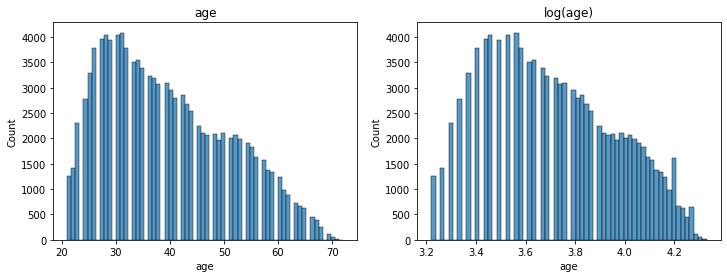

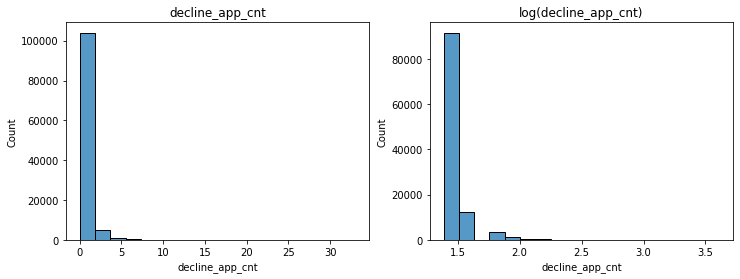

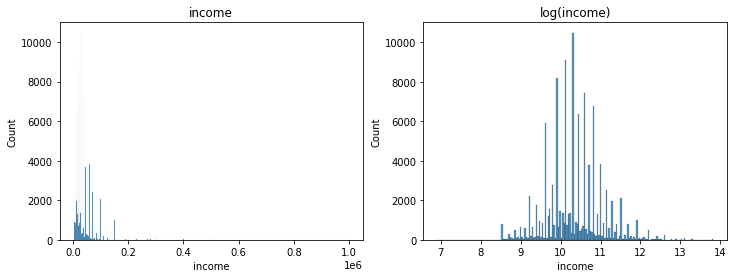

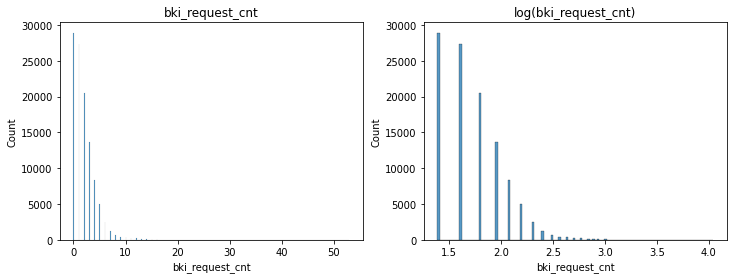

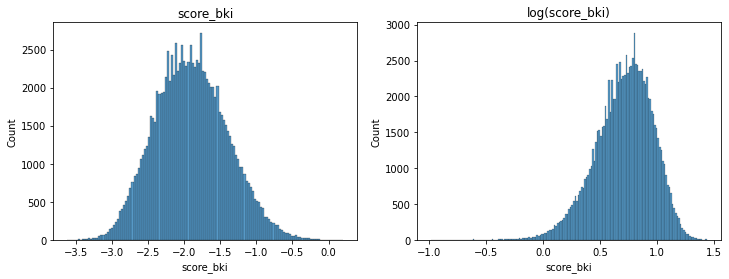

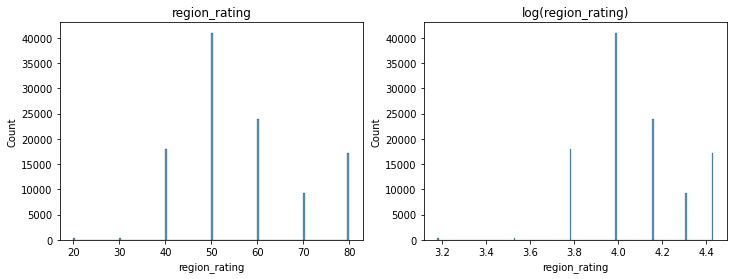

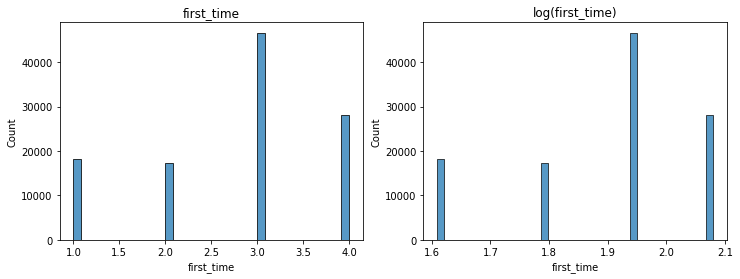

In [16]:
# Посмотрим на распределение численных данных:
for i in num_cols:
    f, ax = plt.subplots(figsize=(25, 4))
    
    # выборка исх данные
    plt.subplot(1, 4, 1)
    sns.histplot(data[i])
    plt.title(i)
    
    # выборка после логарифмирования
    plt.subplot(1, 4, 2)
    sns.histplot(np.log(4+data[i]))
    plt.title('log(' + i + ')')

Наблюдаем что распределения не являются нормальными и смещены вправо, при построении модели необходимо будет выполнить стандартизацию численных признаков.

##### 4. Оценка корреляции

<AxesSubplot:>

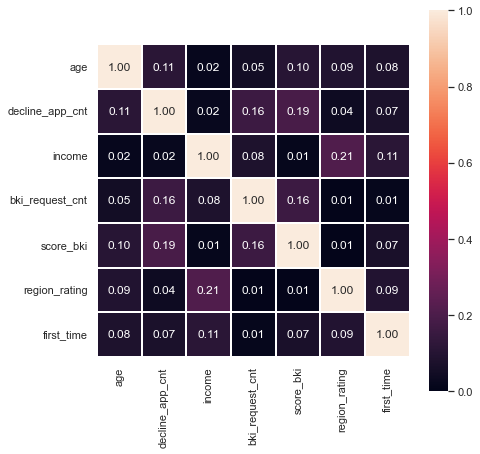

In [17]:
# Посмотрим матрицу коэффициента корреляции численных признаком
sns.set(font_scale = 1)
fig, axis = plt.subplots(figsize=(7,7))
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1, square=True,
           annot=True, fmt=".2f", linewidths=0.1)

Исходя из данной матрицы корреляции видно, что признаки между собой скореллированы слабо. Поэтому оставим их все для модели.

##### 5. Значимость численных признаков

Для оценки значимости численных переменных будем использовать функцию f_classif из библиотеки sklearn.
В основе метода оценки значимости переменных лежит однофакторный дисперсионный анализ (ANOVA).


<AxesSubplot:>

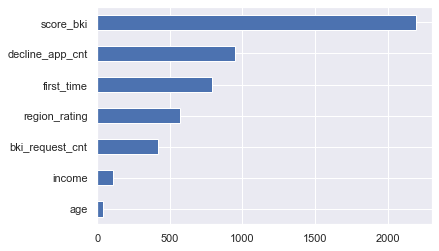

In [18]:
imp_num = pd.Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

score_bki является одним из самых значимых численных признаков

## Категориальные признаки

### Преобразование данных

In [19]:
# Преобразуем дату в день
data['app_date'] = pd.to_datetime(data['app_date'])
data['app_date'] = data['app_date'].apply(lambda x: x.month)

# Переведем дату в катеогрию "численные", т.к. в дальнейшем это влияет на метрики модели
cat_cols.remove('app_date')
num_cols.append('app_date')

In [20]:
# Для преобразования категориальных признаков к численным значениям используем LabelEncoder
label_encoder = LabelEncoder()

for column in cat_cols:
    data[column] = label_encoder.fit_transform(data[column])

# убедимся в преобразовании    
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,3,1,M,29,Y,Y,0,0,-2.271884,3,50,0,1,50000,0,4,N,0,0
1,17527,1,3,F,39,N,N,5,0,-1.504999,2,50,0,1,5000,3,3,N,0,0
2,75683,3,4,M,50,Y,Y,0,0,-1.691339,1,50,0,1,30000,0,3,Y,0,0
3,26883,2,3,M,56,N,N,0,0,-2.374182,1,40,0,1,17000,0,3,N,0,0
4,28862,2,1,F,38,N,N,0,0,-2.487502,0,80,1,2,120000,0,3,N,0,0


<AxesSubplot:>

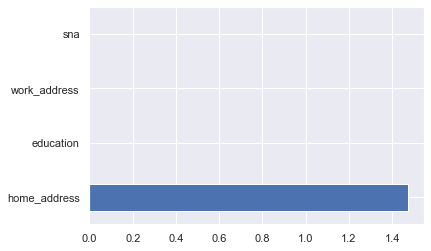

In [21]:
# Рассматриваем значимость категориальных признаков
imp_cat = Series(mutual_info_classif(data[cat_cols], data['default'],
                                     discrete_features = True), index = cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

### Оценка категориальных признаков

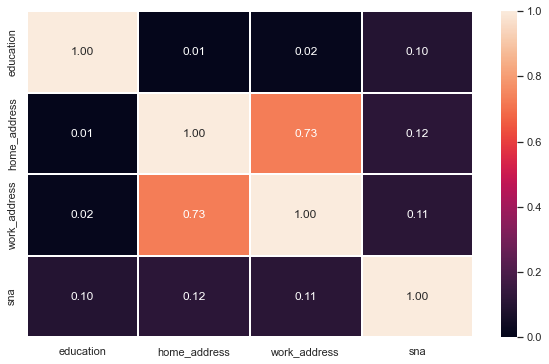

In [22]:
# Построим матрицу корреляций для категориальных признаков:
f = plt.subplots(figsize=(10, 6))
sns.heatmap(data.query('sample == 1')[cat_cols].corr().abs(), vmin=0,
            vmax=1, annot=True, fmt=".2f", linewidths=0.1);

Можно увидеть, что home_address и work_address имеют корреляцию между собой, удалим менее значимый (work_address)

In [23]:
data = data.drop(columns=['work_address'])
cat_cols.remove('work_address')

### Бинарные признаки

In [24]:
# Для преобразования бинарных признаков к численным значениям используем LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

# убедимся в преобразовании    
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,3,1,1,29,1,1,0,0,-2.271884,3,50,1,50000,0,4,0,0,0
1,17527,1,3,0,39,0,0,5,0,-1.504999,2,50,1,5000,3,3,0,0,0
2,75683,3,4,1,50,1,1,0,0,-1.691339,1,50,1,30000,0,3,1,0,0
3,26883,2,3,1,56,0,0,0,0,-2.374182,1,40,1,17000,0,3,0,0,0
4,28862,2,1,0,38,0,0,0,0,-2.487502,0,80,2,120000,0,3,0,0,0


<AxesSubplot:>

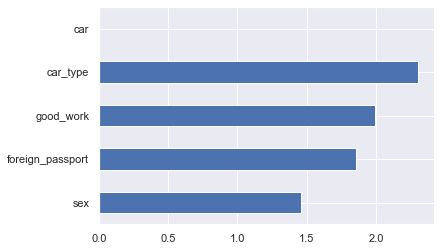

In [25]:
# Рассматриваем значимость бинарных признаков
imp_bin = Series(mutual_info_classif(data[bin_cols], data['default'],
                                     discrete_features = True), index = bin_cols)
imp_bin.sort_values(inplace = True)
imp_bin.plot(kind = 'barh')

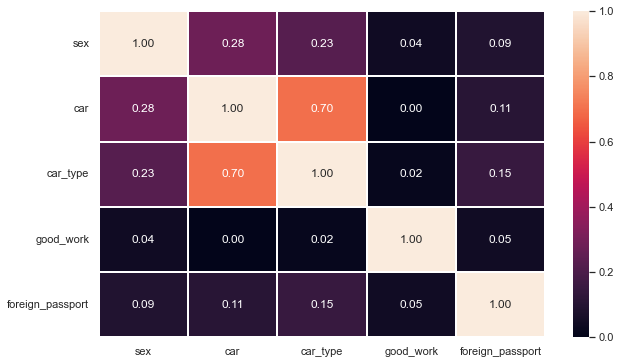

In [26]:
# Построим матрицу корреляций для бинарных признаков:
f = plt.subplots(figsize=(10, 6))
sns.heatmap(data.query('sample == 1')[bin_cols].corr().abs(), vmin=0,
            vmax=1, annot=True, fmt=".2f", linewidths=0.1);

car и car_type коррелируются между собой, удалим car как менее значимый

In [27]:
data = data.drop(columns=['car'])
bin_cols.remove('car')

### Создание новых категориальных признаков или полиномиальных признаков существенно не повлияли на оценки модели - добавлять их не будем

## Подготовка данных для обучения

In [28]:
# выполним стандартизацию численных переменных
data[num_cols] = pd.DataFrame(StandardScaler().fit_transform(data[num_cols]),
                              columns=num_cols)


In [29]:
# Разделим обратно на train и test
train = data.query('sample == 1').drop(['sample'], axis=1)
test = data.query('sample == 0').drop(['sample'], axis=1)

In [30]:
# удалим для X целевую переменную и client_id
X = train.drop(columns = ['default', 'client_id'])
Y = train['default']


In [31]:
# Разделим выборку на train и test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = RANDOM_SEED,
                                                    test_size=0.2)

## Обучение модели

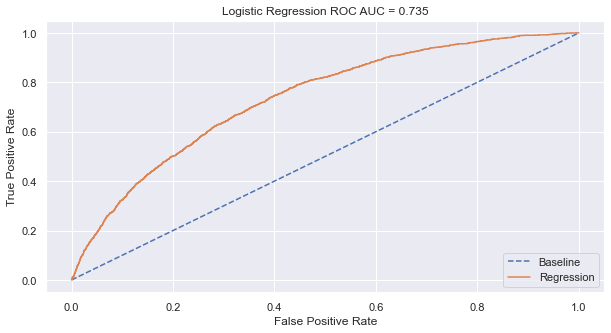

In [32]:
# Построим модель логистической регресии с параметрами "по умолчанию"
model = LogisticRegression()
model.fit(X_train, Y_train)
probs = model.predict_proba(X_test)
y_pred = model.predict(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(Y_test, probs)
roc_auc = roc_auc_score(Y_test, probs)

fig, ax = plt.subplots(figsize=(10,5))
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
ax.set_title('Logistic Regression ROC AUC = %0.3f'%roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')

In [33]:
print('accuracy_score: {}'.format(np.round(accuracy_score(Y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(Y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(Y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(Y_test, y_pred), 4)))

accuracy_score: 0.8742
f1_score: 0.0353
recall_score: 0.0186
MSE: 0.1258


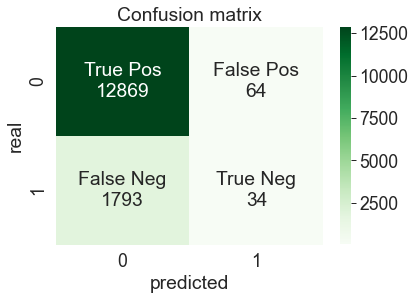

In [34]:
# Визуализация confusion matrix:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Pos', 'False Pos', 'False Neg', 'True Neg']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(Y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
ax = sns.heatmap(confusion_matrix(Y_test, y_pred), annot=labels, fmt='', cmap='Greens')
ax.set(xlabel='predicted', ylabel='real',title = 'Confusion matrix')
plt.show()

Модель имеет достаточно высокую точность, однако, как видно из матрицу ошибок, что почти во всех случаях, когда клиент не способен выплатить кредит - модель все равно его выдаст.
Данное решение приведет к падению доходов банка. Попробуем найти оптимальные гиперпараметры.

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.2s finished


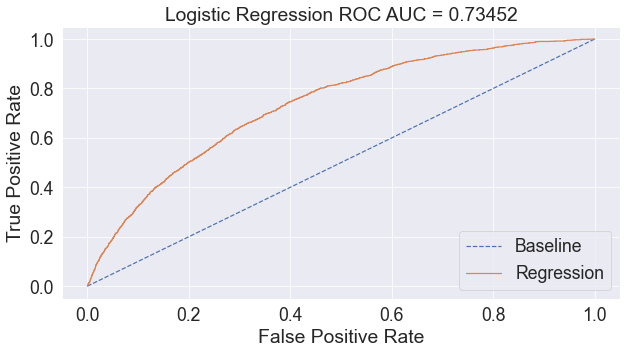

In [35]:
# Попробуем поменять class_weight и с помощью GridSearchCV найти оптимальные параметры (гиперпараметры)
lr_best = LogisticRegression(class_weight='balanced',
                            random_state=RANDOM_SEED)

params = {'C': np.linspace(0.001, 100, 5),
         'max_iter': np.linspace(start=1,stop=1000,num=10, dtype=int)}

model_best = GridSearchCV(lr_best, param_grid=params, verbose=1, cv=2)

model_best.fit(X_train, Y_train)
probs = model_best.predict_proba(X_test)
y_pred = model_best.predict(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(Y_test, probs)
roc_auc = roc_auc_score(Y_test, probs)

fig, ax = plt.subplots(figsize=(10,5))
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
ax.set_title('Logistic Regression ROC AUC = %0.5f'%roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')

In [36]:
print('accuracy_score: {}'.format(np.round(accuracy_score(Y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(Y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(Y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(Y_test, y_pred), 4)))

accuracy_score: 0.6665
f1_score: 0.334
recall_score: 0.6754
MSE: 0.3335


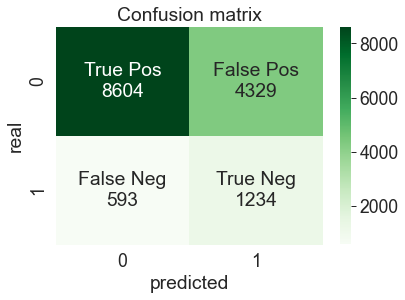

In [37]:
# Визуализация confusion matrix:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Pos', 'False Pos', 'False Neg', 'True Neg']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(Y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
ax = sns.heatmap(confusion_matrix(Y_test, y_pred), annot=labels, fmt='', cmap='Greens')
ax.set(xlabel='predicted', ylabel='real',title = 'Confusion matrix')
plt.show()

После применение изменений (гиперпараметров) - модель ошибалась более часто и не выдает кредит клиентам, которые его выплатят.

#### Так, как у нас целевая переменная несбалансированная - попробуем применить undersampling

In [38]:
# Выберем случайным образом из train['default']==0 такое количество строк, которое
# равнялось бы train['default']==1, и затем объединим с train['default']==1.
under_train = pd.concat([train[train['default']==0].sample(
    len(train[train['default']==1]), random_state=RANDOM_SEED), train[train['default']==1]])

X = under_train.drop(columns = ['default', 'client_id'])
Y = under_train['default']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = RANDOM_SEED,
                                                    test_size=0.2)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.0s finished


Лучшие параметры модели:  {'C': 25.0000075, 'max_iter': 56}


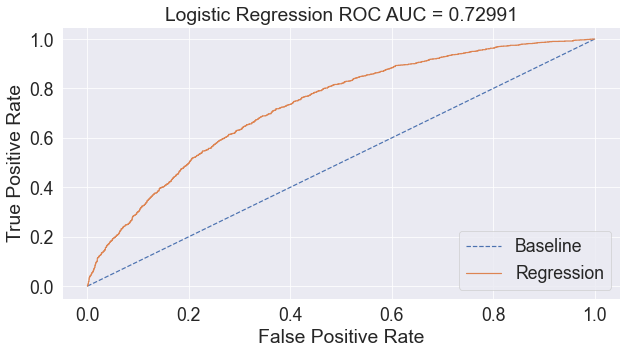

In [39]:
# Попробуем поменять class_weight и с помощью GridSearchCV найти оптимальные параметры
lr_best = LogisticRegression(class_weight='balanced',
                            random_state=RANDOM_SEED)

params = {'C': np.linspace(0.00001, 100, 5),
         'max_iter': np.linspace(start=1,stop=500,num=10, dtype=int)}

model_best = GridSearchCV(lr_best, param_grid=params, verbose=1, cv=2)

model_best.fit(X_train, Y_train)
probs = model_best.predict_proba(X_test)
y_pred = model_best.predict(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(Y_test, probs)
roc_auc = roc_auc_score(Y_test, probs)

fig, ax = plt.subplots(figsize=(10,5))
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
ax.set_title('Logistic Regression ROC AUC = %0.5f'%roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')

print("Лучшие параметры модели: ", model_best.best_params_)

In [40]:
print('accuracy_score: {}'.format(np.round(accuracy_score(Y_test, y_pred), 4)))
print('f1_score: {}'.format(np.round(f1_score(Y_test, y_pred), 4)))
print('recall_score: {}'.format(np.round(recall_score(Y_test, y_pred), 4)))
print('MSE: {}'.format(np.round(mean_squared_error(Y_test, y_pred), 4)))

accuracy_score: 0.6698
f1_score: 0.669
recall_score: 0.6719
MSE: 0.3302


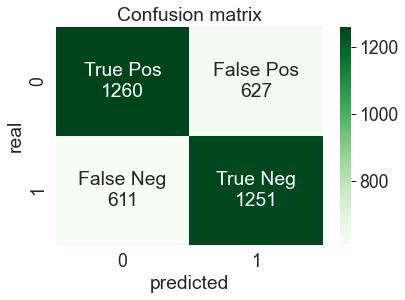

In [41]:
# Визуализация confusion matrix:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Pos', 'False Pos', 'False Neg', 'True Neg']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(Y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
ax = sns.heatmap(confusion_matrix(Y_test, y_pred), annot=labels, fmt='', cmap='Greens')
ax.set(xlabel='predicted', ylabel='real',title = 'Confusion matrix')
plt.show()

В целом неплохо, модель лучше стала предсказывать.

In [42]:
X_test_ = test.drop(columns = ['default', 'client_id'])
y_probs = model_best.predict_proba(X_test_)[:,1]

In [43]:
test['default'] = y_probs

In [44]:
submission = test[['client_id','default']]
display(submission.sample(10))
display(submission.shape)

,client_id,default
24904,108611,0.358592
30981,44973,0.485320
33985,108106,0.478618
35306,3782,0.586914
11747,50705,0.396406
5471,15315,0.750026
35645,59786,0.566692
35969,102171,0.334251
35387,59123,0.611607
12070,65687,0.323749


(36349, 2)

In [45]:
submission.to_csv(DATA_DIR + 'submission.csv', index=False)